In [1]:
import string
from collections import Counter

import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import pandas as pd
pd.set_option("display.max_rows", 999)
pd.set_option('max_colwidth',100)
import numpy as np
from IPython.display import display

In [2]:
# taking csv prepared earlier to explore data 

filepath = "email_data.csv"
# Read the data into a pandas dataframe called emails

df_email = pd.read_csv(filepath)

headers = [header for header in df_email.columns]

print("Successfully loaded {} rows and {} columns!".format(df_email.shape[0], df_email.shape[1]))

Successfully loaded 517401 rows and 9 columns!


In [3]:
'''def cleanemail(email):
    return ' '.join([s.strip() for s in email.splitlines()][15:])

df_email['email-body'] = df_email['Message-Body'].apply(cleanemail)'''

In [3]:
df_email.head(3)

,email-body,From,employee,Date,Subject,X-Folder,To,X-cc,X-Origin
0,Here is our forecast,phillip.allen@enron.com,allen-p,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",NaN,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Sent Mail",tim.belden@enron.com,NaN,Allen-P
1,Traveling to have a business meeting takes the fun out of the trip. Especially if you have to ...,phillip.allen@enron.com,allen-p,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",Re:,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Sent Mail",john.lavorato@enron.com,NaN,Allen-P
2,test successful. way to go!!!,phillip.allen@enron.com,allen-p,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",Re: test,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,leah.arsdall@enron.com,NaN,Allen-P


In [6]:
#df_email = df_email.drop(columns=['message', 'file', 'X-bc', 'Message-Body'])

In [6]:
df_email['To']

0               tim.belden@enron.com
1            john.lavorato@enron.com
2             leah.arsdall@enron.com
3              randall.gay@enron.com
4               greg.piper@enron.com
                     ...            
517396          kori.loibl@enron.com
517397       john.lavorato@enron.com
517398         dawn.doucet@enron.com
517399        jeanie.slone@enron.com
517400    livia_zufferli@monitor.com
Name: To, Length: 517401, dtype: object

In [7]:
df_email['From']

0         phillip.allen@enron.com
1         phillip.allen@enron.com
2         phillip.allen@enron.com
3         phillip.allen@enron.com
4         phillip.allen@enron.com
                   ...           
517396    john.zufferli@enron.com
517397    john.zufferli@enron.com
517398    john.zufferli@enron.com
517399    john.zufferli@enron.com
517400    john.zufferli@enron.com
Name: From, Length: 517401, dtype: object

In [8]:
# Convert date column to datetime 

df_email["Date"] = pd.to_datetime(df_email["Date"])

In [9]:
df_email["X-Folder"].sample(7)

55287       \MCUILLA (Non-Privileged)\Cuilla, Martin\Sent Items
495174           \Kim_Watson_Mar2002\Watson, Kimberly\Glen Hass
142736              \John_Griffith_Nov2001\Notes Folders\Market
45420         \Larry_Campbell_Jun2001\Notes Folders\Notes inbox
74978         \Jeff_Dasovich_June2001\Notes Folders\Notes inbox
243587         \Steven_Kean_June2001_3\Notes Folders\California
277657    \MLENHAR (Non-Privileged)\Lenhart, Matthew\Sent Items
Name: X-Folder, dtype: object

In [10]:
def preprocess_folder(data):   
    folders = []
    for item in data:
        if item is None or item is '':
            folders.append(np.nan)
        else:
            item = str(item).split('\\')[-1]
            item = item.lower()
            folders.append(item)
    print("Folder cleaned!")
    return folders


df_email["X-Folder"] = preprocess_folder(df_email["X-Folder"])

<>:4: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:4: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-10-68ad560b9e2d>:4: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if item is None or item is '':


Folder cleaned!


In [11]:
# Folders we can filter out
unwanted_folders = ["all documents", "discussion threads", "sent","inbox",
                   "sent items", "'sent mail", "untitled", "notes inbox", "junk file", "calendar"]

# A new dataframe without non-topical folders
df_folder = df_email.loc[~df_email['X-Folder'].isin(unwanted_folders)]

print(df_folder["X-Folder"].value_counts())

deleted items                  50987
personal                        2642
attachments                     2026
meetings                        1872
schedule crawler                1398
                               ...  
project grandslam                  1
exmerge - baughman jr., don        1
bpa                                1
cousins                            1
dra                                1
Name: X-Folder, Length: 1772, dtype: int64


In [86]:
# taking some random folder to check 

resumes = df_folder.loc[df_folder['X-Folder'] == "federal gov't affairs"]

In [90]:
resumes.loc[438857]['email-body']
#emails.loc[25]["message"]

"X-FileName: rshapiro.nsf  FYI:  I see a few other Enron names on the list of recipients, but thought I should pass this on.  Jimmy is a friend of mine from church.  Eric  -----Original Message----- From:  Jimmy Glotfelty <jimmyg@calpine.com>@ENRON [mailto:IMCEANOTES-Jimmy+20Glotfelty+20+3Cjimmyg+40calpine+2Ecom+3E+40ENRON@EN RON.com] Sent: Friday, June 01, 2001 12:10 PM To: 'Thomas O. Moore'; 'Rebecca Turner Gonzales'; 'sruhlen@ovp.eop.gov'; 'brianthomas@etrademail.com'; 'kristan.mack@mail.house.gov'; 'Kathleen Magruder'; john.stauffacher@dynegy.com; barry.huddleston@dynegy.com; breilley@coral-energy.com; kim.casey@dynegy.com; eheuss@texas.net; 'dana.gresham@mail.house.gov'; 'Joel Bluestein'; Greenwald, Steven; 'Black, Andy'; Bud Albright (E-mail); Jeff MacKinnon (E-mail); Cynthia Sandherr (E-mail); Robertson, Linda; 'ssegal@bracepatt.com'; Kerrill Scrivner (E-mail); 'ellen@txlobby.com'; 'swonkec@tcbaus.com'; 'ahachtman@aol.com'; 'liberallib@aol.com'; 'David Gross'; 'BSTURGEON@austin.

In [91]:
resumes.head(3)

,email-body,From,employee,Date,Subject,X-Folder,To,X-cc,X-Origin,year
438857,"X-FileName: rshapiro.nsf FYI: I see a few other Enron names on the list of recipients, but tho...",eric.thode@enron.com,shapiro-r,2001-06-01 12:22:00+00:00,FW: Duty Calls,federal gov't affairs,"richard.shapiro@enron.com, steven.kean@enron.com, mark.palmer@enron.com, \n\tjanel.guerrero@enro...",NaN,SHAPIRO-R,2001
438858,X-Origin: SHAPIRO-R X-FileName: rshapiro.nsf 26 RULES FOR BEING A GOOD REPUBLICAN IN 21st CENTU...,lara.leibman@enron.com,shapiro-r,2001-03-15 10:56:00+00:00,Being a Good Republican,federal gov't affairs,"fred.enochs@enron.com, david.reinfeld@enron.com, brian.bradford@enron.com, \n\trichard.shapiro@e...",NaN,SHAPIRO-R,2001
438859,Please see the attached memorandum. - 03-06-01 Hearing.doc,epsa@mindspring.com,shapiro-r,2001-03-07 14:17:00+00:00,House Subcommittee Hearing on California's Electricity Market,federal gov't affairs,rshapiro@enron.com,NaN,SHAPIRO-R,2001


In [70]:
## Define a function which can be applied to calculate the score for the whole dataset

'''def senti(x):
    #return TextBlob(x).sentiment  
    score = SentimentIntensityAnalyzer().polarity_scores(x)
    if score['neg'] > score['pos']:
        print("Negative Sentiment")
    elif score['neg'] < score['pos']:
        print("Positive Sentiment")
    else:
        print("Neutral Sentiment")
    return score
        
cya['senti_score'] = cya['email-body'].apply(senti)  
'''


'def senti(x):\n    #return TextBlob(x).sentiment  \n    score = SentimentIntensityAnalyzer().polarity_scores(x)\n    if score[\'neg\'] > score[\'pos\']:\n        print("Negative Sentiment")\n    elif score[\'neg\'] < score[\'pos\']:\n        print("Positive Sentiment")\n    else:\n        print("Neutral Sentiment")\n    return score\n        \ncya[\'senti_score\'] = cya[\'email-body\'].apply(senti)  \n'

In [71]:
# removing outliers from subset of Folder dataset
#Convert date column to datetime 

df_folder["Date"] = pd.to_datetime(df_folder["Date"], utc = True)

### Adding classification by year to dataframe:
### Datetime is set as an idex and column year is added
df_folder['year'] = pd.DatetimeIndex(df_folder['Date']).year

#### Selection of years of interest:
Folder = df_folder[df_folder.year > 1998]
Folder = Folder[Folder.year < 2003]

<ipython-input-71-6787e79825cb>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_folder["Date"] = pd.to_datetime(df_folder["Date"], utc = True)
<ipython-input-71-6787e79825cb>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_folder['year'] = pd.DatetimeIndex(df_folder['Date']).year


In [56]:
#Convert date column to datetime 

df_email["Date"] = pd.to_datetime(df_email["Date"], utc = True)

### Adding classification by year to dataframe:
### Datetime is set as an idex and column year is added
df_email['year'] = pd.DatetimeIndex(df_email['Date']).year

#### Selection of years of interest:
data = df_email[df_email.year > 1998]
data = data[data.year < 2003] 

In [57]:
data = df_email.drop_duplicates(['email-body'])

In [73]:

## Define a function which can be applied to calculate the score for the whole dataset

def senti(x):
    #return TextBlob(x).sentiment  
    score = SentimentIntensityAnalyzer().polarity_scores(x)
    if score['neg'] > score['pos']:
        print("Negative Sentiment")
    elif score['neg'] < score['pos']:
        print("Positive Sentiment")
    else:
        print("Neutral Sentiment")
    return score

# funtion for preprocessing of data 

#midway = df_folder.loc[df_folder['X-Folder'] == 'midway']

def sentiment_preprocess(data):
    
    data = Folder.loc[Folder['X-Folder'] == 'data']
    
    ## Change the email type to string
    data['email.text'] = data['email-body'].astype(str)
    
    ## Lowercase all email
    data['email.text'] = data['email.text'].apply(lambda x: " ".join(x.lower() for x in x.split())) 
    
    stop_words = stopwords.words('english')
    stop_words.extend(['enron', 'com', 're', 'RECIPIENTS', 'CN', 'ENRON', 'OU', 'NA', 'Thank', 'mail', 'know', 'get', 'Thanks', 'one', 'let', 'cc', 'bc', 'subject', 'http', 'www', 'hotmail', 'email', 'would', 'back', 'time', 'bcc','new', 'aol', 'Com', 'Original Message','message'])
    
    stop = stopwords.words('english')

    data['email.text'] = data['email.text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))    
    
    st = PorterStemmer()

    data['email.text'] = data['email.text'].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))
    
    data['senti_score'] = data['email.text'].apply(senti)
    
    print (data['senti_score'])
    
    return  data['senti_score']


In [27]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer, PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob

In [38]:
import nltk
nltk.download('stopwords')

sentiment_preprocess('resumes')

In [40]:
#red_rock['senti_score']

cya = df_folder.loc[df_folder['X-Folder'] == 'cya']




(-0.5, 799.5, 599.5, -0.5)

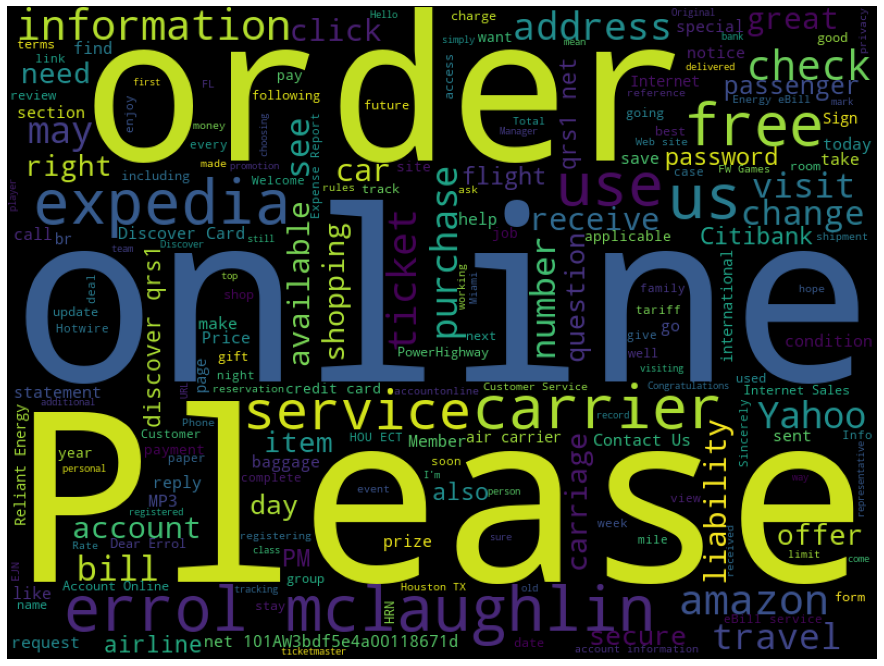

In [69]:
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from nltk.corpus import stopwords
import wordcloud

stop_words = stopwords.words('english')
stop_words.extend(['enron', 'com', 're', 'RECIPIENTS', 'CN', 'ENRON', 'OU', 'NA', 'Thank', 'mail', 'know', 'get', 'Thanks', 'one', 'let', 'cc', 'bc', 'subject', 'http', 'www', 'hotmail', 'email', 'would', 'back', 'time', 'bcc','new', 'aol', 'Com', 'Original Message','message'])

subjects = ' '.join( personal_stuff['email-body'])

fig, ax = plt.subplots(figsize=(16, 12))

wc = wordcloud.WordCloud(width=800, 
                         height=600, 
                         max_words=200,
                         stopwords=stop_words).generate(subjects)
ax.imshow(wc)
ax.axis("off")

In [37]:
'''import nltk.data
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import sentiment
from nltk import word_tokenize

# Next, we initialize VADER so we can use it within our Python script
sid = SentimentIntensityAnalyzer()

# We will also initialize our 'english.pickle' function and give it a short name

tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

resumes['email-body'] = 

message_text = resumes['email-body']
# The tokenize method breaks up the paragraph into a list of strings. In this example, note that the tokenizer is confused by the absence of spaces after periods and actually fails to break up sentences in two instances. How might you fix that?

sentences = tokenizer.tokenize(message_text)

# We add the additional step of iterating through the list of sentences and calculating and printing polarity scores for each one.

for sentence in sentences:
        print(sentence)
        scores = sid.polarity_scores(sentence)
        for key in sorted(scores):
                print('{0}: {1}, '.format(key, scores[key]), end='')'''

"import nltk.data\nfrom nltk.sentiment.vader import SentimentIntensityAnalyzer\nfrom nltk import sentiment\nfrom nltk import word_tokenize\n\n# Next, we initialize VADER so we can use it within our Python script\nsid = SentimentIntensityAnalyzer()\n\n# We will also initialize our 'english.pickle' function and give it a short name\n\ntokenizer = nltk.data.load('tokenizers/punkt/english.pickle')\n\nresumes['email-body'] = \n\nmessage_text = resumes['email-body']\n# The tokenize method breaks up the paragraph into a list of strings. In this example, note that the tokenizer is confused by the absence of spaces after periods and actually fails to break up sentences in two instances. How might you fix that?\n\nsentences = tokenizer.tokenize(message_text)\n\n# We add the additional step of iterating through the list of sentences and calculating and printing polarity scores for each one.\n\nfor sentence in sentences:\n        print(sentence)\n        scores = sid.polarity_scores(sentence)\n   

In [94]:
import nltk.data
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import sentiment
from nltk import word_tokenize

# Next, we initialize VADER so we can use it within our Python script
sid = SentimentIntensityAnalyzer()

# We will also initialize our 'english.pickle' function and give it a short name

tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

message_text = ''' Duty Calls  It is with mixed emotions that I must announce that I will be leaving Calpine effective Friday, June 8th.  I have been asked by the Bush Administration to go back and serve again.  In my new life, beginning on June 11th, I will be the Senior Electric Policy Advisor to Energy Secretary Spencer Abraham.  In this role I will be responsible for helping craft the Administration's electric restructuring bill, evaluate the feasibility of a national electric grid, help advise the administration on the steps necessary to help solve our western electric crisis, work with Congress, and help craft many other policies that will positively impact the competitive electric industry.  This is a once in a lifetime opportunity that I felt I could not pass up.  I do not yet have a new email but will forward it when I get it.  My new phone number is 202-586-7131 (after June 11th).  Jimmy Glotfelty Director; Government Affairs Calpine Corporation 700 Milam #800 Houston, TX 77002 Direct: 713-830-8633 Fax: 713-830-8871 Cell: 713-594-8153 jimmyg@calpine.com" '''
# The tokenize method breaks up the paragraph into a list of strings. In this example, note that the tokenizer is confused by the absence of spaces after periods and actually fails to break up sentences in two instances. How might you fix that?

sentences = tokenizer.tokenize(message_text)

# We add the additional step of iterating through the list of sentences and calculating and printing polarity scores for each one.

for sentence in sentences:
        print(sentence)
        scores = sid.polarity_scores(sentence)
        for key in sorted(scores):
                print('{0}: {1}, '.format(key, scores[key]), end='')

 Duty Calls  It is with mixed emotions that I must announce that I will be leaving Calpine effective Friday, June 8th.
compound: 0.4767, neg: 0.0, neu: 0.853, pos: 0.147, I have been asked by the Bush Administration to go back and serve again.
compound: 0.0, neg: 0.0, neu: 1.0, pos: 0.0, In my new life, beginning on June 11th, I will be the Senior Electric Policy Advisor to Energy Secretary Spencer Abraham.
compound: 0.2732, neg: 0.0, neu: 0.9, pos: 0.1, In this role I will be responsible for helping craft the Administration's electric restructuring bill, evaluate the feasibility of a national electric grid, help advise the administration on the steps necessary to help solve our western electric crisis, work with Congress, and help craft many other policies that will positively impact the competitive electric industry.
compound: 0.9081, neg: 0.061, neu: 0.651, pos: 0.288, This is a once in a lifetime opportunity that I felt I could not pass up.
compound: 0.4215, neg: 0.0, neu: 0.797, p

###  codes to add subjectivity and polarity in dataset

In [43]:
import re, math, collections, itertools
import nltk, nltk.classify.util, nltk.metrics
from nltk.classify import NaiveBayesClassifier
from nltk.metrics import BigramAssocMeasures
from nltk.probability import FreqDist, ConditionalFreqDist
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer

In [ ]:
'''def calculate_subjectivity (text):
    """ uses TextBlob to calculate subjectivity """
    testimonial = TextBlob(text)
    return testimonial.sentiment.subjectivity 

def calculate_polarity(text):
    """ uses TextBlob to calculate polarity """
    testimonial = TextBlob(text)
    return testimonial.sentiment.polarity

df_folder['subjectivity '] = df_folder['email-body'].apply(lambda x: calculate_subjectivity(x))
df_folder['polarity'] = df_folder['email-body'].apply(lambda x: calculate_polarity(x))'''

# saved the 'df_folder' as csv ---- Folder.csv

#already done in Folder CSV

In [ ]:
# For adding sentiment score in dataframe

In [41]:
df = pd.read_csv("Folder.csv")

In [42]:
df.head(2)

,email-body,From,employee,Date,Subject,X-Folder,To,X-cc,X-Origin,year,subjectivity,polarity
0,Here is our forecast,phillip.allen@enron.com,allen-p,2001-05-14 23:39:00+00:00,NaN,'sent mail,tim.belden@enron.com,NaN,Allen-P,2001,0.00000,0.000000
1,Traveling to have a business meeting takes the fun out of the trip. Especially if you have to ...,phillip.allen@enron.com,allen-p,2001-05-04 20:51:00+00:00,Re:,'sent mail,john.lavorato@enron.com,NaN,Allen-P,2001,0.60303,0.181818


In [66]:
blob = TextBlob("I love this library", analyzer=NaiveBayesAnalyzer())
blob.sentiment[1]

0.7996209910191279

In [78]:
def calculate_sentiment(text, attribute='classification'):
    """ using http://textblob.readthedocs.org/en/latest/advanced_usage.html """
    blob = TextBlob(text, analyzer=NaiveBayesAnalyzer())
    
    #sentiments = blob.sentiment[0]
    
    #pos = blob.sentiment[1]
    print (blob.sentiment[2])
    return blob.sentiment[2]
    
    #return pd.Series(['sentiments', 'pos', 'neg'], index = ['sentiments', 'pos', 'neg'])
    #return blob.sentiment.__dict__[attribute]

In [45]:
# for calling calculate_sentiment function
import swifter

In [79]:
cya['neg'] = cya['email-body'].swifter.apply(lambda x :calculate_sentiment(x))

0.10168637778452817
2.2101300243957955e-05
1.550289169939612e-05
0.001745768392873585
2.1321182914250377e-12
0.0056617533267745235
2.5765451126452568e-05
0.00488887248651972
0.0008292579732397171
3.08126421125878e-05
9.196217697267636e-11
0.0008060882092167519
4.0668692036347546e-19
2.697145958818207e-23
1.0234150886647444e-05
0.003386041344203741
0.0017402340851730457
0.0005121177560036249
0.49796662024532434
0.00019816919341475288
0.00535939979749881
0.04618557570571794
2.482978772325825e-09
6.295384598246761e-10
1.7936112132427003e-05
4.242580208306654e-11
0.20567458669566369
5.266536461016133e-07
0.0025055439452145384



,email-body,From,employee,Date,Subject,X-Folder,To,X-cc,X-Origin,year,subjectivity,polarity,sentiment,pos,neg
301425,X-Origin: WHITE-S X-FileName: stacy white 7-15-02.PST Below is 670939 confirm. The 3 deals wer...,l..denton@enron.com,white-s,2001-12-12 17:27:41+00:00,Entergy Services Deals,cya,h..moore@enron.com,"White, Stacey W. </O=ENRON/OU=NA/CN=RECIPIENTS/CN=Swhite>",WHITE-S,2001,0.369286,0.106429,sentiments,pos,0.101686
301426,"X-Origin: WHITE-S X-FileName: stacy white 7-15-02.PST yes, this was a non-DPR flash item -----...",theresa.vos@enron.com,white-s,2001-10-15 15:09:44+00:00,RE: New Albany Loss,cya,w..white@enron.com,"Hardy, Trey </O=ENRON/OU=NA/CN=RECIPIENTS/CN=Thardy>",WHITE-S,2001,0.427652,0.100379,sentiments,pos,0.000022


In [81]:
#cya['sentiment'] = cya['email-body'].swifter.apply(lambda x: calculate_sentiment(x, attribute='classification'))
#df['p_pos'] = df.text.apply(lambda x: calculate_sentiment_nb(x, attribute='p_pos'))
#df['p_neg'] = df.text.apply(lambda x: calculate_sentiment_nb(x, attribute='p_neg'))

### Using NRCLex lib for emotion score

In [89]:
from nrclex import NRCLex
# https://pypi.org/project/NRCLex/
'''
NRCLex will measure emotional affect from a body of text. Affect dictionary contains approximately 27,000 words, 
and is based on the National Research Council Canada (NRC)affect lexicon (see link below) 
and the NLTK library's WordNet synonym sets.
'''

In [87]:
def emotion(x):
    text_object = NRCLex(x)
    fear = text_object.affect_frequencies['fear']
    anger = text_object.affect_frequencies['anger']
    anticip = text_object.affect_frequencies['anticip']
    trust = text_object.affect_frequencies['trust']
    surprise = text_object.affect_frequencies['surprise']
    positive = text_object.affect_frequencies['positive']
    negative = text_object.affect_frequencies['negative']
    sadness = text_object.affect_frequencies['sadness']
    disgust = text_object.affect_frequencies['disgust']
    joy = text_object.affect_frequencies['joy']
    topemotion = text_object.top_emotions[0][0]
    return pd.Series([fear, anger, anticip, trust, surprise, positive, negative, sadness, disgust, joy, topemotion], index=['fear', 'anger', 'anticip', 'trust', 'surprise', 'positive', 'negative', 'sadness', 'disgust', 'joy', 'topemotion'])

In [92]:
df[['fear', 'anger', 'anticip', 'trust', 'surprise', 'positive', 'negative', 'sadness', 'disgust', 'joy', 'topemotion']] = df['email-body'].swifter.apply(lambda x : emotion(x))


In [93]:
df.head(3)

,email-body,From,employee,Date,Subject,X-Folder,To,X-cc,X-Origin,year,...,anger,anticip,trust,surprise,positive,negative,sadness,disgust,joy,topemotion
0,Here is our forecast,phillip.allen@enron.com,allen-p,2001-05-14 23:39:00+00:00,NaN,'sent mail,tim.belden@enron.com,NaN,Allen-P,2001,...,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,fear
1,Traveling to have a business meeting takes the fun out of the trip. Especially if you have to ...,phillip.allen@enron.com,allen-p,2001-05-04 20:51:00+00:00,Re:,'sent mail,john.lavorato@enron.com,NaN,Allen-P,2001,...,0.094070,0.096115,0.106339,0.089980,0.114519,0.104294,0.100204,0.096115,0.100204,positive
2,test successful. way to go!!!,phillip.allen@enron.com,allen-p,2000-10-18 10:00:00+00:00,Re: test,'sent mail,leah.arsdall@enron.com,NaN,Allen-P,2000,...,0.083333,0.111111,0.111111,0.083333,0.111111,0.111111,0.111111,0.083333,0.111111,anticip


In [95]:
df.to_csv('score.csv', index=False)
#emails.to_csv('email_data.csv',index=False)

In [97]:
PKA = df.groupby(['From', 'To'])

In [101]:
PKA.get_group(('pete.davis@enron.com', 'pete.davis@enron.com')).count()

email-body       9141
From             9141
employee         9141
Date             9141
Subject          9133
X-Folder         9141
To               9141
X-cc             9141
X-Origin         9141
year             9141
subjectivity     9141
polarity         9141
fear             9141
anger            9141
anticip          9141
trust            9141
surprise         9141
positive         9141
negative         9141
sadness          9141
disgust          9141
joy              9141
topemotion       9141
dtype: int64

In [99]:
df['From'].value_counts().head(5)

pete.davis@enron.com         9147
jeff.dasovich@enron.com      7918
kay.mann@enron.com           5432
tana.jones@enron.com         4998
sara.shackleton@enron.com    4797
Name: From, dtype: int64

In [100]:
df['To'].value_counts().head(5)

pete.davis@enron.com         9154
tana.jones@enron.com         2981
sara.shackleton@enron.com    2874
jeff.dasovich@enron.com      2603
louise.kitchen@enron.com     2223
Name: To, dtype: int64

In [103]:
df[df['From']=='tim.belden@enron.com']

,email-body,From,employee,Date,Subject,X-Folder,To,X-cc,X-Origin,year,...,anger,anticip,trust,surprise,positive,negative,sadness,disgust,joy,topemotion
640,---------------------- Forwarded by Tim Belden/HOU/ECT on 12/05/2000 05:44 AM -----------------...,tim.belden@enron.com,allen-p,2000-12-05 06:42:00+00:00,"New Generation, Nov 30th",all documents,phillip.allen@enron.com,NaN,Allen-P,2000,...,0.076923,0.076923,0.230769,0.000000,0.153846,0.153846,0.153846,0.000000,0.076923,trust
4605,check this out and let everyone know what's up. ---------------------- Forwarded by Tim Belden/...,tim.belden@enron.com,badeer-r,2000-08-20 21:12:00+00:00,RE: Path 26 OTC increase -- IMPORTANT,all documents,"robert.badeer@enron.com, jeff.richter@enron.com",NaN,Badeer-R,2000,...,0.096118,0.094270,0.114603,0.085028,0.120148,0.105360,0.099815,0.090573,0.096118,positive
4631,"Please see the attached. Christian, could you coordinate the writing of this letter. ---------...",tim.belden@enron.com,badeer-r,2000-08-15 06:23:00+00:00,PX Letter,all documents,"robert.badeer@enron.com, christian.yoder@enron.com",NaN,Badeer-R,2000,...,0.088235,0.117647,0.125000,0.080882,0.117647,0.095588,0.095588,0.080882,0.110294,trust
4656,put this into the congestion redesign file if you haven't alread. ---------------------- Forwar...,tim.belden@enron.com,badeer-r,2000-08-08 09:51:00+00:00,CAISO Congestion Model,all documents,robert.badeer@enron.com,NaN,Badeer-R,2000,...,0.095017,0.096176,0.111240,0.085747,0.111240,0.117034,0.100811,0.093859,0.093859,negative
4674,X-Origin: Badeer-R X-FileName: rbadeer.nsf i would categorize things in the following manner: ...,tim.belden@enron.com,badeer-r,2000-08-01 06:32:00+00:00,information from iso,all documents,jeff.dasovich@enron.com,"Robert Badeer, Jeff Richter",Badeer-R,2000,...,0.094810,0.091816,0.116766,0.082834,0.113772,0.111776,0.088822,0.103792,0.096806,trust
4751,"X-To: Chris H Foster, Murray P O'Neil, John M Forney, Tim Heizenrader, Mike Swerzbin, Robert Bad...",tim.belden@enron.com,badeer-r,2000-08-28 15:15:00+00:00,Out of Office,all documents,"chris.foster@enron.com, murray.o'neil@enron.com, john.forney@enron.com, \n\ttim.heizenrader@enro...",NaN,Badeer-R,2000,...,0.095694,0.090909,0.119617,0.086124,0.100478,0.105263,0.100478,0.105263,0.095694,trust
4782,X-Origin: Badeer-R X-FileName: rbadeer.nsf We have had some confusion recently with respect to ...,tim.belden@enron.com,badeer-r,2000-08-28 09:50:00+00:00,Out of Office Procedure,all documents,"mike.swerzbin@enron.com, robert.badeer@enron.com, sean.crandall@enron.com, \n\ttim.belden@enron....",NaN,Badeer-R,2000,...,0.098214,0.102679,0.102679,0.084821,0.116071,0.120536,0.093750,0.089286,0.089286,negative
4787,X-FileName: rbadeer.nsf Check this out. I think that we need to be signed up for this. -------...,tim.belden@enron.com,badeer-r,2000-08-28 06:11:00+00:00,ISO To Participate in Super Peak Market,all documents,"john.forney@enron.com, robert.badeer@enron.com, greg.wolfe@enron.com, \n\tjeff.richter@enron.com...",NaN,Badeer-R,2000,...,0.098097,0.098097,0.111274,0.093704,0.107613,0.105417,0.097365,0.092972,0.098097,trust
4936,"X-To: Chris H Foster, Murray P O'Neil, John M Forney, Tim Heizenrader, Mike Swerzbin, Robert Bad...",tim.belden@enron.com,badeer-r,2000-08-28 15:15:00+00:00,Out of Office,discussion threads,"chris.foster@enron.com, murray.o'neil@enron.com, john.forney@enron.com, \n\ttim.heizenrader@enro...",NaN,Badeer-R,2000,...,0.095694,0.090909,0.119617,0.086124,0.100478,0.105263,0.100478,0.105263,0.095694,trust
4988,"X-To: Chris H Foster, Murray P O'Neil, John M Forney, Tim Heizenrader, Mike Swerzbin, Robert Bad...",tim.belden@enron.com,badeer-r,2000-08-28 15:15:00+00:00,Out of Office,notes inbox,"chris.foster@enron.com, murray.o'neil@enron.com, john.forney@enron.com, \n\ttim.heizenrader@enro...",NaN,Badeer-R,2000,...,0.095694,0.090909,0.119617,0.086124,0.100478,0.105263,0.100478,0.105263,0.095694,trust
